Part 2 contents:

1. Feature engineering
2. Feature selection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
#  load and join the two datasets
campaign_df = pd.read_csv("../Datasets/Campaign.csv", sep=",", header=0)
mortgage_df = pd.read_csv("../Datasets/Mortgage.csv", sep=",", header=0)

full_df = pd.concat([campaign_df, mortgage_df], axis=1, join="inner")

Processing of salary

In [3]:
# we have information about the salary of each campaign participant
# this information is not well stored and needs processing
full_df["salary_band"].str.split(" ").str[-1].unique()
# from a first view that amounts are stored as yearkly, weekly, month etc, also in different currencies like JMD and LBP
# define all amounts as yearly and GBP

array(['yearly', 'pw', 'month', ..., '184489.46LBP',
       '3897121941089.38GHS', '17374400.84JMD'], dtype=object)

Salaries stored in British pounds values acount for 90.04% of the entries.
Endings for the british pound salaries are the following: yearly, pw, per month, - range


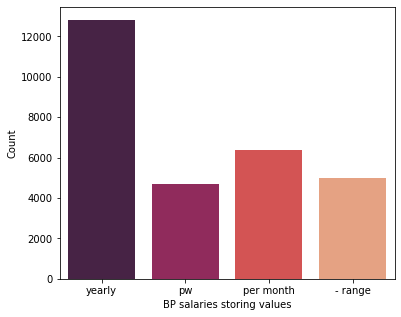

In [4]:
# --- --- --- helpers --- --- ---
british_pound=u"\xA3"
bp_salaries_flag = full_df["salary_band"].str.startswith(british_pound)

# find the british salaries ending value
def isfloat(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


def isnumeric(s):
    return (s.isnumeric() or isfloat(s))


def salary_converter(salary_band: str, conv_from: str=None) -> float:
    """Convert a weekly or monthly salary to yearly
    """
    # british pound sign
    bp_sign = u"\xA3"

    if conv_from:
        if conv_from not in ["pw", "per month", "yearly"]:
            raise ValueError('The value for "conv_from" must be one of "pw", "per month" or "yearly".')
    else:
        # define the conv_from
        conv_from = " ".join([x for x in salary_band.split(bp_sign)[1].split(" ") if not isnumeric(x)])

    salary = float(salary_band.split(bp_sign)[-1].split(conv_from)[0].strip())

    # define a conversion dictionary with multiplication values
    conv_dict = {
        "pw": 52.14,
        "per month": 12,
        "yearly": 1
        }
    
    yearly_salary = round(salary*conv_dict[conv_from], 2)    
    return yearly_salary


bp_endings = full_df[bp_salaries_flag]["salary_band"].apply(lambda x: " ".join([x for x in x.split(british_pound)[1].split(" ") if not isnumeric(x)]))
bp_endings_unique = bp_endings.unique()

print(f"Salaries stored in British pounds values acount for {round(bp_salaries_flag.sum()/full_df.shape[0]*100, 2)}% of the entries.")
print(f"Endings for the british pound salaries are the following: {', '.join(bp_endings_unique)}")

# there are yearly, per week and per month salaries and also a range
plt.figure(figsize=(6, 5))
splot = sns.countplot(x=bp_endings.tolist(), palette='rocket')
splot.set(xlabel="BP salaries storing values",
          ylabel="Count")
plt.show()

# most values are stored per year, so I will change the rest of the values to a yearly amount
# 1st convert the salaries that do not contain salary ranges
full_df["yearly_salary_estimate"] = np.nan
non_range_bp_salaries_flag = (bp_salaries_flag & ~ full_df["salary_band"].str.contains("range"))

full_df.loc[non_range_bp_salaries_flag, "yearly_salary_estimate"] = full_df.loc[non_range_bp_salaries_flag, :]["salary_band"].apply(salary_converter)

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_37696\3224762526.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Based on the plots, the mean value for the range seems as a good candidate to use in the yearly salary estimate


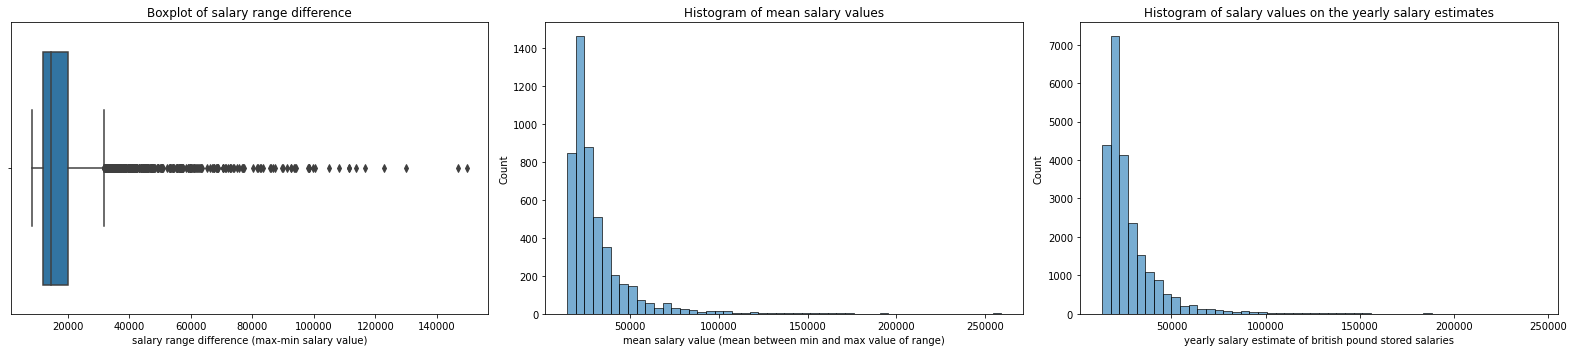

In [5]:
# salaries that are stored in ranges
range_salaries = full_df[bp_salaries_flag & full_df["salary_band"].str.contains("range")]["salary_band"].tolist()
min_of_range = [float(s.split(british_pound)[1].split("-")[0].strip()) for s in range_salaries]
max_of_range = [float(s.split(british_pound)[1].split("-")[1].strip().split(" ")[0]) for s in range_salaries]

range_salaries_df = pd.DataFrame(data={"salary_min": min_of_range, "salary_max": max_of_range})
salary_range_diff =  range_salaries_df["salary_max"] - range_salaries_df["salary_min"]
salary_mean = (range_salaries_df["salary_max"]+range_salaries_df["salary_min"])/2

range_salaries_df = range_salaries_df.assign(
    range_diff = salary_range_diff,
    salary_mean = salary_mean
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
splot = sns.boxplot(data=range_salaries_df, x="range_diff", ax=axes[0])
splot.set(title="Boxplot of salary range difference",
          xlabel="salary range difference (max-min salary value)")

splot = sns.histplot(data=range_salaries_df, x="salary_mean", bins=50, alpha=0.6, ax=axes[1])
splot.set(title="Histogram of mean salary values",
          xlabel="mean salary value (mean between min and max value of range)")

splot = sns.histplot(data=full_df, x="yearly_salary_estimate", bins=50, alpha=0.6, ax=axes[2])
splot.set(title="Histogram of salary values on the yearly salary estimates",
          xlabel="yearly salary estimate of british pound stored salaries")

plt.tight_layout()
fig.show()

print("Based on the plots, the mean value for the range seems as a good candidate to use in the yearly salary estimate")


# fix it
def mean_from_salary_range(salary_band: str) -> float:
    """Calculate the mean salary value given a range of values for a salary
    """
    if not "range" in salary_band:
        raise ValueError("Salary range provided needs to be in the form 'min salary-max salary range")
    
    # remove the currency sign
    bp_sign = u"\xA3"
    salary_range = salary_band.replace(bp_sign, "")

    min_salary_value = float(salary_range.split(" ")[0])
    max_salary_value = float(salary_range.split("-")[1].strip().split(" ")[0])
    mean_salary = (min_salary_value + max_salary_value)/2

    return round(mean_salary, 2)


range_bp_salaries_flag = (bp_salaries_flag & full_df["salary_band"].str.contains("range"))
full_df.loc[range_bp_salaries_flag, "yearly_salary_estimate"]  = full_df[range_bp_salaries_flag]["salary_band"].apply(mean_from_salary_range)

In [6]:
# there is still a 10% of salary entries that are not calculated in british pounds
# there are not british pound salaries that appear to have missing salary value -- I will remove them
problematic_indexes =\
    full_df[~bp_salaries_flag][full_df[~bp_salaries_flag]["salary_band"].str.split(r"[A-Z]").str[0].apply(lambda x: not isnumeric(x))].index

full_df = full_df.drop(problematic_indexes.tolist())
full_df = full_df.reset_index(drop=True)


# calculate british pound salary flag again, as there has been a re-indexing
bp_salaries_flag = full_df["salary_band"].str.startswith(british_pound)

# Note that the currency converter does not query the API in real time, to avoid the overhead of the HTTP request.
# It uses embedded data in the library, which might not be up to date
# Default source is European Central Bank
# project link: https://github.com/alexprengere/currencyconverter
from currency_converter import CurrencyConverter, SINGLE_DAY_ECB_URL
import re

cur_conv = CurrencyConverter(SINGLE_DAY_ECB_URL)

def convert_to_gbp(salary_band: str) ->float:
    """
    Converts an input string in the format <salary><surrency> to GBP salary
    Requirements:
        Import re module
        Uses a pre-defined currency converter as cur_conv
    """
    salary = float(re.split(r"[A-Z]", salary_band)[0])
    currency_orig = re.sub('[^A-Z]', '', salary_band)

    if currency_orig in cur_conv.currencies:
        gbp_salary = round(cur_conv.convert(salary, currency_orig, "GBP"), 2)
    else:
        gbp_salary = np.nan
    
    return gbp_salary



conv_salaries = full_df[~bp_salaries_flag]["salary_band"].apply(convert_to_gbp)
n_missing = conv_salaries.isnull().sum()
print(f"Using the converter, we were able to convert the values of {len(conv_salaries)-n_missing}.")
print(f"This accounts for {round(100 - n_missing/len(conv_salaries)*100, 2)}% of the values that needed to be converted.")

# statistics of the converted currency values
mean_conv_sal = conv_salaries.mean()
std_conv_sal = np.std(conv_salaries)
min_s, max_s = conv_salaries.min(), conv_salaries.max()
print("-- Statistics --")
print(f"Min and max values of the converted salaries are {min_s} and {max_s} respectively.")
print(f"Mean {mean_conv_sal} and standard deviation {std_conv_sal}")

# print the values are very big, there seems to be an issue
# I will retrain only the values that are up to 3 times bigger than the existing max value
# and minimum value larger than 0.5*the min value of estimated yearly salary

to_replace = conv_salaries[conv_salaries>full_df["yearly_salary_estimate"].min()*0.5][conv_salaries<full_df["yearly_salary_estimate"].max()*3]
full_df.iloc[to_replace.index.tolist()]["yearly_salary_estimate"] = to_replace

n_missing = full_df["yearly_salary_estimate"].isnull().sum()
n_missing_w_account = full_df[full_df["yearly_salary_estimate"].isnull()][full_df["created_account"]=="Yes"].shape[0]
n_account = full_df[full_df["created_account"]=="Yes"].shape[0]

print(f"There are still {n_missing} missing values in the estimated yearly salaries.")
print(f"Of them, {n_missing_w_account} had created an account ({round(n_missing_w_account/n_account*100, 2)}%of all accounts)")

# they need to be removed
full_df = full_df.loc[~full_df["yearly_salary_estimate"].isnull(), :].reset_index(drop=True)


Using the converter, we were able to convert the values of 647.
This accounts for 20.91% of the values that needed to be converted.
-- Statistics --
Min and max values of the converted salaries are 0.29 and 38837766990749.81 respectively.
Mean 217719024388.53165 and standard deviation 2246043411165.179
There are still 3094 missing values in the estimated yearly salaries.
Of them, 18 had created an account (7.56%of all accounts)


C:\Users\Anastasia\AppData\Local\Temp\ipykernel_37696\1168398146.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.iloc[to_replace.index.tolist()]["yearly_salary_estimate"] = to_replace
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_37696\1168398146.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_missing_w_account = full_df[full_df["yearly_salary_estimate"].isnull()][full_df["created_account"]=="Yes"].shape[0]


Time with employer processing

In [7]:
# round months with employer information -- if >=6 months -->+1 year else +0 year
full_df.loc[full_df["months_with_employer"]>=6, "years_with_employer"] =\
    full_df.loc[full_df["months_with_employer"]>=6, "years_with_employer"]+1

Capital loss/ gain

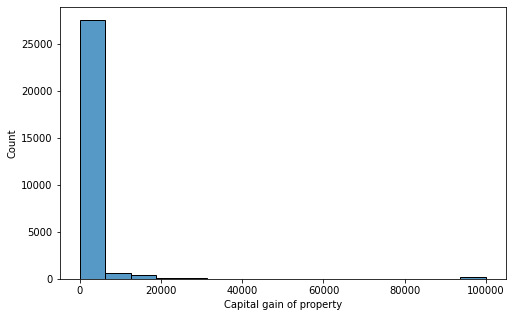

In [8]:
# since the mortgages are all new, then capital gain and capital loss are from estimation?
# we can replace the two columns with a column that defines if a property has been evaluated or not (there are no missing values)
# and another that sets default capital_evaluation to 0, positive value when there is gain, negative when there is loss
# data are also clear -- no entrie has both gain and loss

# replace capital loss with negative value
full_df.loc[:, "capital_loss"] = full_df.loc[:, "capital_loss"]*-1

# the max value of capital_gain is 99999 -- seems like a default max
plt.figure(figsize=(8, 5))
splot = sns.histplot(data=full_df, x="capital_gain")
splot.set(xlabel="Capital gain of property")
plt.show()

# the properties that are estimated with a capital gain of 99999 will be replaced with the mean capital gain estimation
mean_gain = int(full_df[(full_df["capital_gain"]>0) & (full_df["capital_gain"]!=99999)]["capital_gain"].mean())
full_df.loc[full_df["capital_gain"]==99999, "capital_gain"] = mean_gain

# add the two new columns and remove the original ones
full_df["capital_estimate"] = 0
full_df.loc[(full_df["capital_gain"]!=0) | (full_df["capital_loss"]!=0), "capital_estimate"] = 1

full_df["capital_evaluation"] = full_df["capital_gain"] + full_df["capital_loss"]

full_df = full_df.drop(columns=["capital_gain", "capital_loss"])

Working hours per week

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_37696\1968418003.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


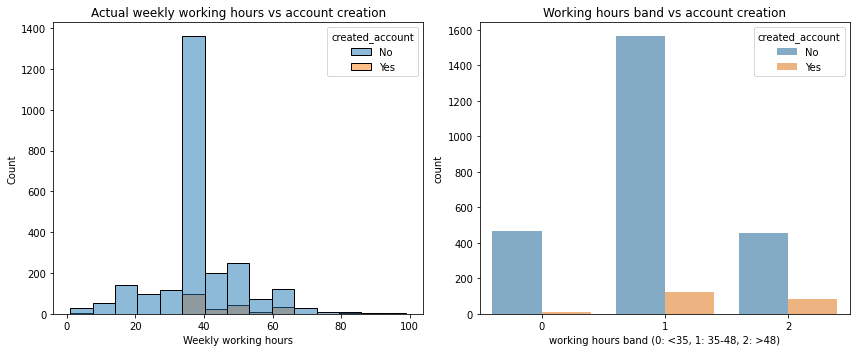

In [9]:
# hours per week takes a range of values as well
# it can also be encoded into a characeteristic with fewer values
# for example <35 (0) --> part time, 35-48 -->full time (legal -- majority of jobs) (1), >48 -->overtime (2)
# https://www.gov.uk/maximum-weekly-working-hours
# https://www.gov.uk/part-time-worker-rights
# I will add it here, but I will keep both in the dataset
full_df["hours_band"] = 0
full_df.loc[(full_df["hours_per_week"]>=35) & (full_df["hours_per_week"]<48), "hours_band"]=1
full_df.loc[full_df["hours_per_week"]>48, "hours_band"]=2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

splot  = sns.histplot(data=full_df, x="hours_per_week", hue="created_account", ax=axes[0], bins=15)
splot.set(title="Actual weekly working hours vs account creation",
          xlabel="Weekly working hours")

splot = sns.countplot(data=full_df, x="hours_band", hue="created_account", alpha=0.6, ax=axes[1])
splot.set(title="Working hours band vs account creation",
          xlabel="working hours band (0: <35, 1: 35-48, 2: >48)")

plt.tight_layout()
fig.show()

Feature selection

In [10]:
# the following columns should not be used by any predictive algorithm, as they are direct identifiers of the campaign participant

participant_identifier_cols = [
    "participant_id",
    "first_name",
    "last_name",
    "postcode",
    "company_email",
    "full_name",
    "dob",
    "paye",
    "religion",
    "native_country",
    "name_title",
    "race"
]

full_df = full_df.drop(columns=participant_identifier_cols)


# also there are columns that contain information that we have incorporated in other columns
# salary_band --> yearly_salary_estimate
# education --> 1:1 mapping with education_num
# new_mortgage --> all participants of the campaign have new mortgages -- not providing information
# months_owth_employer --> information added to years_with_employer
# we can remove them as well

# open to decide
# town --> it has many unique values (2356) and it is specific to participant, but it also probably the town of the new house
# which is a major factor of the house's value and in turn its resale value (capital gain/loss)

remove_cols = [
    "salary_band",
    "education",
    "new_mortgage",
    "months_with_employer",
]

full_df = full_df.drop(columns=remove_cols)

In [11]:
# job title has many different vales (689)
# there are values that appear only in the positive outcome of the campaign like "Prime Minister" or "Air broker"
# but I will not keep it (future cycle, maybe with some embeddings) --- elaborate
# the same goes for the town value
# or even keep them, and after processing lower the number of dataset dimensions using dimentionality reduction techniques
full_df = full_df.drop(columns=["town", "job_title", "relationship"])

In [17]:
# store the data for easy access
full_df.to_csv("../Datasets/ready_to_model_data.csv", sep=",", index=False)